In [1]:
from helpers import *
from dataset import *
from model2_for48 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import precision_score, recall_score, f1_score
from monai.transforms import RandFlipd,RandRotated,RandZoomd,RandAffined,ResizeD,SpatialPadd,RandRotate90d,EnsureChannelFirstd,Orientationd,RandAdjustContrastd,RandGaussianNoised

In [2]:
DEBAG = False
#DEBAG = True

In [3]:
mask_size2 = {key: math.floor(value * 0.8) for key, value in mask_size.items()}
mask_size2

{'defolt': 0,
 'apo-ferritin': 4,
 'beta-amylase': 5,
 'beta-galactosidase': 7,
 'ribosome': 12,
 'thyroglobulin': 10,
 'virus-like-particle': 11}

In [4]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.05,
        'beta-amylase': 0.05,
        'beta-galactosidase': 0.05,
        'ribosome': 0.05,
        'thyroglobulin': 0.05,
        'virus-like-particle': 0.20,
    }, 
)

(30, 184, 630, 630)
(30, 184, 630, 630)


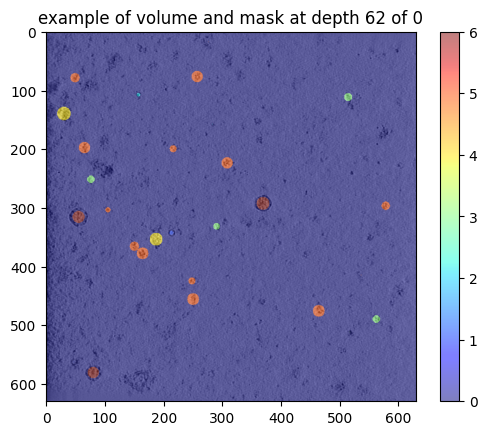

In [5]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

diff =["denoised","isonetcorrected","wbp","ctfdeconvolved"]
diff =["denoised","isonetcorrected","wbp","ctfdeconvolved","denoised"]
#diff =["denoised"]

valid_id = ['TS_99_9', "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
if DEBAG:
    valid_id = ["TS_5_4"]
test_id = ["TS_5_4"]

volumes = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id)*len(diff), 184, 630, 630), dtype=np.uint8)

n = 0
for idx in range(len(valid_id)):
    for diff_type in diff:
        data = read_diff_data(valid_id[idx], train_dir, diff_type)
        data = data.astype(np.float32)
        volumes[n, :, :, :] = data
        
        y = read_one_truth(valid_id[idx], mask_dir)
        mask_data = generate_mask(y, mask_size2)
        mask_data = mask_data.astype(np.uint8)
        masks[n, :, :, :] = mask_data
        n += 1
print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=62)

In [6]:
class VolumeDatasetSlices(Dataset):
    def __init__(self, vol_data, mask_data, patch_size=32, stride=16, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            mask_data (numpy.ndarray): 形状 (N, D, H, W) を想定 (例: (N, 184, 640, 640))
            patch_size (int): 切り出したい深さ方向のスライス数 (例: 32)
            stride (int): スライドウィンドウの移動量 (例: 16)
            transform (callable, optional): MONAIの辞書ベースTransformsなど
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.indices = []
        # 全サンプルに対してスライスの開始・終了位置をまとめる
        for idx in range(len(vol_data)):
            d = vol_data[idx].shape[0]  # 深さ(D次元)の大きさ
            # 0, stride, 2*stride, ... のように動かしながら、patch_sizeぶん取り出せる範囲でスライス
            for start in range(0, d - patch_size + 1, stride):
                #ランダムに動かす
                start = start + random.randint(-stride//2, stride//2)
                end = start + patch_size
                # (サンプル番号, スライス開始, スライス終了) を記録
                #マスクが含まれるスライスのみを記録
                if np.sum(mask_data[idx][start:end]) > 0:
                    self.indices.append((idx, start, end))

    def __len__(self):
        # スライスの総数を返す
        return len(self.indices)

    def __getitem__(self, i):
        idx, start, end = self.indices[i]

        # （idx番目のボリューム・マスク） のうち, 深さ方向を [start:end] で切り出す
        volume = self.vol_data[idx][start:end]  # (patch_size, H, W)
        mask   = self.mask_data[idx][start:end] # (patch_size, H, W)

        data_dict = {"image": volume, "label": mask}
        if self.transform:
            data_dict = self.transform(data_dict)

        return data_dict["image"], data_dict["label"]

# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    # 1. Tensor形式に変換
    ToTensorD(keys=["image", "label"]),
    
    # 2. チャンネルの次元を先頭に移動
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    
    # 3. データをRAS方向に揃える
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    
    # 4. ランダム90度回転を適用
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    
    # 5. ランダム反転 (空間軸 0 に沿って)
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    
    # 6. パディングを適用して (32, 640, 640) に拡張
    SpatialPadd(keys=["image", "label"], spatial_size=(32, 640, 640), mode="constant"),
    
    # 7. ランダムな平行移動とスケール、回転を適用
    RandAffined(
        keys=["image", "label"],
        prob=0.5,  # 適用確率
        rotate_range=(0.1, 0.1, 0.1),  # 回転範囲 (ラジアン単位, 各軸: X, Y, Z)
        translate_range=(0, 100, 100),  # 平行移動範囲 (各軸: X, Y, Z)
        mode=("bilinear", "nearest"),  # 補間方法 (画像: bilinear, ラベル: nearest)
        padding_mode="border"  # 境界の埋め方
    ),
    
    # 8. ランダムコントラスト調整
    RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.8, 1.2)),  # コントラストを80%~120%に変更
])


In [7]:
dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=transforms
)
raw_dataset = VolumeDatasetSlices(
    vol_data=volumes, 
    mask_data=masks, 
    patch_size=32, 
    stride=16,
    transform=None
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
no_transform_dataloader = DataLoader(raw_dataset, batch_size=1, shuffle=True)
# データを取り出す
#i = 0
#print(len(dataloader))  # 6
#for volume, mask in dataloader:
#    i += 1
#    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
#    print_slices(volume[0], mask[0], dim=3, idx=0, depth=16)
#    if i == 3:
#        break

265
torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


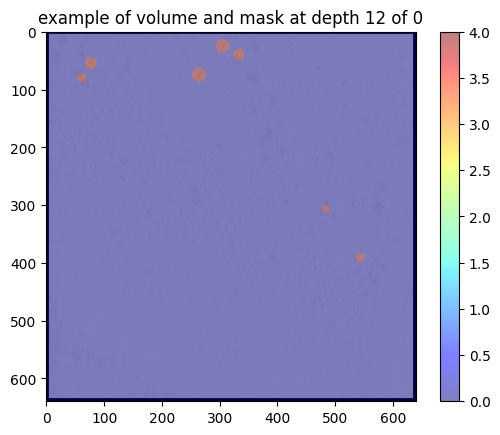

388809.0


torch.Size([1, 1, 32, 640, 640]) torch.Size([1, 1, 32, 640, 640])


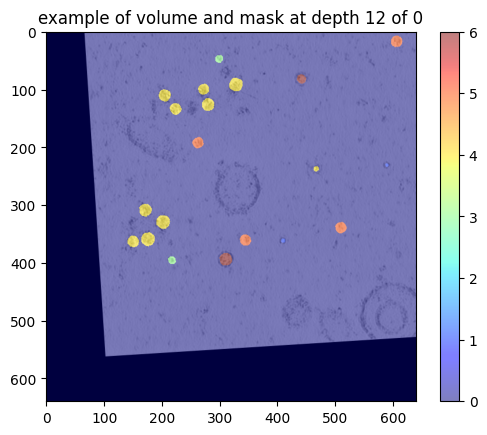

677833.0


In [8]:
 #データを取り出す
i = 0
print(len(dataloader))  # 6
for volume, mask in dataloader:
    i += 1
    print(volume.shape, mask.shape)  # torch.Size([1, 32, 640, 640]) torch.Size([1, 32, 640, 640])
    print_slices(volume[0], mask[0], dim=4, idx=0, depth=12)
    #print_volume_slices(mask[0], dim=4, idx=0, depth=12)
    print(np.sum(mask[0].numpy()))
    if i == 2:
        break

In [9]:
GPU_ID = 4
device = torch.device(f'cuda:{GPU_ID}' if torch.cuda.is_available() else 'cpu')
print(device)
net = Net(pretrained=True,cfg=None).to(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

cuda:4


In [10]:
global train_batch, test_batch

In [11]:
from torch.optim.lr_scheduler import LambdaLR

# 学習ループにCV計算を追加
num_epochs = 30
learning_rate = 1e-3
accumulation_steps = 4  # 勾配を累積するステップ数

optimizer = torch.optim.AdamW(
    net.parameters(),
    amsgrad=False,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable=False,
    eps=1e-08,
    foreach=None,
    fused=None,
    lr=learning_rate,
    weight_decay=0.01
)

warmup_steps = 30
total_steps = num_epochs * len(dataloader)

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))  # 線形ウォームアップ
    return 0.5 * (1. + np.cos(np.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

epoch_losses = []
cv_scores = []  # CVスコアの記録リスト
mask_losses = []

global_step = 0

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        optimizer = torch.optim.AdamW(
            net.parameters(),
            amsgrad=False,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable=False,
            eps=1e-08,
            foreach=None,
            fused=None,
            lr=learning_rate,
            weight_decay=0.01
        )

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        # 1次元削減
        volumes = volumes.squeeze(0)
        masks = masks.squeeze(0)

        batch, D, H, W = volumes.shape

        # パディング
        volumes = np.pad(volumes, [[0, 0], [0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
        masks = np.pad(masks, [[0, 0], [0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)

        if np.sum(masks) == 0:
            continue
        batch = {
            'image': torch.from_numpy(volumes).to(device).float(),
            'mask': torch.from_numpy(masks).to(device).long(),
        }

        #後で検証用に使うために保存
        train_batch = batch

        optimizer.zero_grad(set_to_none=True) if i % accumulation_steps == 0 else None

        with torch.amp.autocast(device_type="cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss'] / accumulation_steps  # 累積ステップ数でスケーリング

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            global_step += 1

        running_loss += loss.item() * accumulation_steps  # スケーリングを戻して加算

    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"訓練_loss: {epoch_loss:.4f}")

    # エポックごとにCVスコアを計算
    gb, lb_score, mask_loss = evaluate_cv(net, test_id, cfg, valid_dir, device, mask_size)  # test_id: 検証用データIDリスト
    cv_scores.append(lb_score)
    #lbスコアが最大のモデルを保存
    if lb_score == max(cv_scores):
        torch.save({'state_dict': net.state_dict()}, '../model/resnet34d.pth')
    mask_losses.append(np.mean(mask_loss))
    print(f"CVスコア: lb_score: {lb_score:.4f}")

# 最終的なスコアを出力
print("\n全エポックの結果:")
for epoch, (loss, lb_score) in enumerate(zip(epoch_losses, cv_scores), start=1):
    print(f"エポック {epoch}: 損失: {loss:.4f}, lb_score: {lb_score:.4f}")

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/30
----------


Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


訓練_loss: 1.3336
検証_loss=0.9793521761894226
['TS_5_4']
 TS_5_4 virus-like-particle
(         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  1  46    0    46   1        0.0     0.0      0.0   
1         beta-amylase  1  10    0    10   1        0.0     0.0      0.0   
2   beta-galactosidase  1  12    0    12   1        0.0     0.0      0.0   
3             ribosome  1  31    0    31   1        0.0     0.0      0.0   
4        thyroglobulin  1  30    0    30   1        0.0     0.0      0.0   
5  virus-like-particle  0  11    0    11   0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  , 0.0)
['TS_5_4']
 TS_5_4 virus-like-particle
CVスコア: lb_score: 0.0000
エポック 2/30
----------
訓練_loss: 0.5681
検証_loss=0.32506653666496277
['TS_5_4']
 TS_5_4 virus-like-particle
(         particle_type     P   T  hit  miss    fp  precision    recall  \
0         apo-ferritin   761  46    0    46   761   

In [12]:
out = output['particle']
out = out.squeeze(0).detach().cpu().numpy()

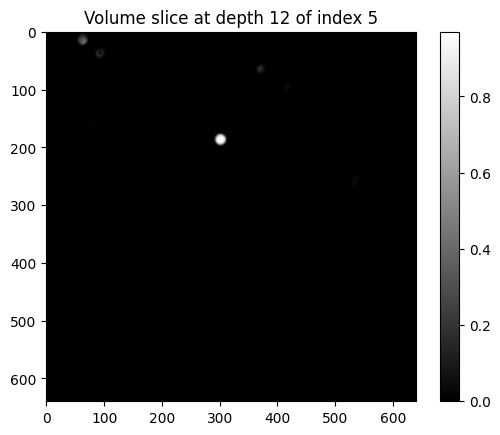

In [13]:
print_volume_slices(out, dim=4, idx=5, depth=12)

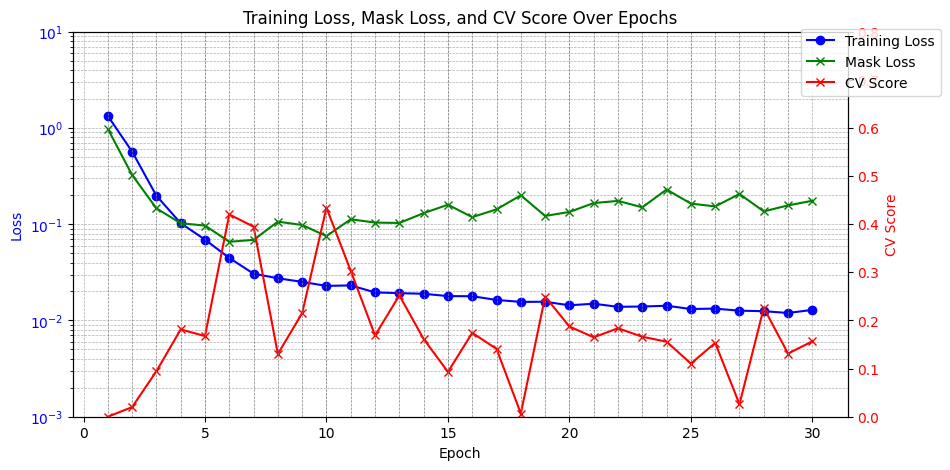

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 左側の軸（Training LossとMask Loss）
ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss', color='blue')
ax1.plot(range(1, len(mask_losses) + 1), mask_losses, marker='x', label='Mask Loss', color='green')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_yscale('log')  # 対数スケール（任意）
ax1.set_ylim(0.001, 10) 
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# 右側の軸（CV Score）
ax2 = ax1.twinx()
ax2.plot(range(1, len(cv_scores) + 1), cv_scores, marker='x', label='CV Score', color='red')
ax2.set_ylabel('CV Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 0.8)

# 凡例を追加
fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
plt.title('Training Loss, Mask Loss, and CV Score Over Epochs')

#薄い線を追加
for i in range(1, len(epoch_losses)):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# グラフ表示
plt.show()

In [15]:
test_id = ['TS_99_9']
net.eval()
submit_df = []

for i, id in enumerate(test_id):
    print(f"Evaluating CV for ID {id} ({i+1}/{len(test_id)})")
    volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
    y = read_one_truth(id, f'{valid_dir}/overlay/ExperimentRuns')
    mask = generate_mask(y, mask_size)
    
    D, H, W = volume.shape

    probability = np.zeros((7, D, H, W), dtype=np.float32)
    count = np.zeros((7, D, H, W), dtype=np.float32)
    pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
    pad_mask = np.pad(mask, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)

    num_slice = 64
    mask_loss =[]
    zz = list(range(0, D - num_slice, num_slice // 2)) + [D - num_slice]
    for z in zz:
        image = pad_volume[z:z + num_slice]
        mask = pad_mask[z:z + num_slice]
        batch = {
            'image': torch.from_numpy(image).unsqueeze(0).to(device).float(),
            'mask': torch.from_numpy(mask).unsqueeze(0).to(device).long(),
        }
        test_batch = batch
        with torch.amp.autocast(device_type="cuda", enabled=True):
            with torch.no_grad():
                output = net(batch)

        #valid loglossを表示
        mask_loss.append(output['mask_loss'].item())

        prob = output['particle'][0].cpu().numpy()
        probability[:, z:z + num_slice] += prob[:, :, :H, :W]
        count[:, z:z + num_slice] += 1

    probability = probability / (count + 0.0001)

Evaluating CV for ID TS_99_9 (1/1)


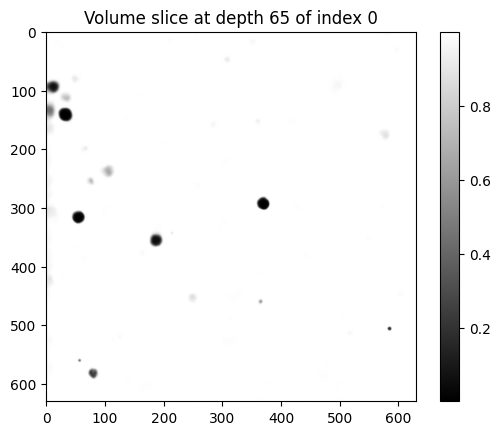

In [16]:
print_volume_slices(probability, dim=4, idx=0, depth=65)

In [17]:
location = probability_to_location(probability, cfg)
submit_df=location_to_df(location)
submit_df.insert(loc=0, column='experiment', value=id)
compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')

['TS_99_9']
 TS_99_9 virus-like-particle


(         particle_type    P   T  hit  miss   fp  precision    recall  \
 0         apo-ferritin  172  36   31     5  141   0.180233  0.861111   
 1         beta-amylase    8  21    0    21    8   0.000000  0.000000   
 2   beta-galactosidase   15  24    4    20   11   0.266667  0.166667   
 3             ribosome  113  65   42    23   71   0.371681  0.646154   
 4        thyroglobulin    8  49    5    44    3   0.625000  0.102041   
 5  virus-like-particle   14  13   13     0    1   0.928571  1.000000   
 
     f-beta4  weight  
 0  0.704545       1  
 1  0.000000       0  
 2  0.170426       2  
 3  0.619254       1  
 4  0.107323       2  
 5  0.995495       1  ,
 0.41068480924300005)

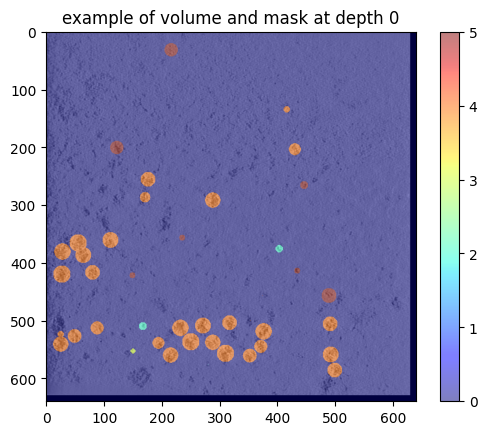

In [18]:
image = batch['image'][0].cpu().numpy()
mask = batch['mask'][0].cpu().numpy()

print_slices(image, mask, dim=3, idx=0, depth=0)